In [7]:
import numpy as np
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
epochs = 20
batch_size = 60
lr = 0.001

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [11]:
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [12]:

train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)


In [13]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 64, 5)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(64 * 1 * 1, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ConvNet().to(device)


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [15]:
total_steps = len(train_loader)
train_losses = []
val_losses = []


for epoch in range(epochs):
    
    model.train()
    epoch_train_losses = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        epoch_train_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 500 == 0:
            print(f'Training - Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{total_steps}], Loss: {loss.item():.4f}')

    train_losses.append(np.mean(epoch_train_losses))

    
    model.eval()
    with torch.no_grad():
        epoch_val_losses = []
        val_correct = 0
        val_total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            val_loss = criterion(outputs, labels)
            epoch_val_losses.append(val_loss.item())

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

        val_losses.append(np.mean(epoch_val_losses))
        val_acc = 100 * val_correct / val_total
        print(f'Validation - Epoch [{epoch + 1}/{epochs}], Loss: {val_losses[-1]:.4f}, Accuracy: {val_acc:.2f}%')

Training - Epoch [1/20], Step [500/900], Loss: 0.9096
Validation - Epoch [1/20], Loss: 0.3643, Accuracy: 89.13%
Training - Epoch [2/20], Step [500/900], Loss: 0.2669
Validation - Epoch [2/20], Loss: 0.2489, Accuracy: 92.55%
Training - Epoch [3/20], Step [500/900], Loss: 0.2295
Validation - Epoch [3/20], Loss: 0.1502, Accuracy: 95.50%
Training - Epoch [4/20], Step [500/900], Loss: 0.2125
Validation - Epoch [4/20], Loss: 0.1187, Accuracy: 96.18%
Training - Epoch [5/20], Step [500/900], Loss: 0.1348
Validation - Epoch [5/20], Loss: 0.1307, Accuracy: 95.95%
Training - Epoch [6/20], Step [500/900], Loss: 0.2219
Validation - Epoch [6/20], Loss: 0.1079, Accuracy: 96.62%
Training - Epoch [7/20], Step [500/900], Loss: 0.1875
Validation - Epoch [7/20], Loss: 0.1042, Accuracy: 96.85%
Training - Epoch [8/20], Step [500/900], Loss: 0.1645
Validation - Epoch [8/20], Loss: 0.0901, Accuracy: 96.97%
Training - Epoch [9/20], Step [500/900], Loss: 0.1876
Validation - Epoch [9/20], Loss: 0.1091, Accuracy:

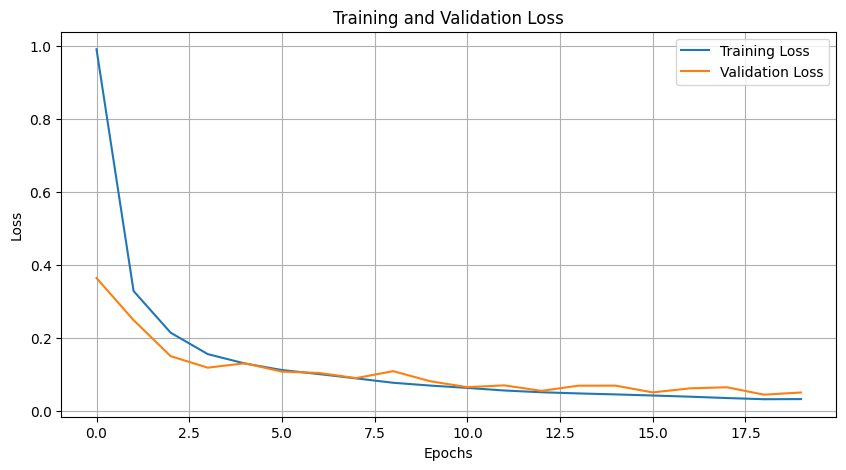

Training and validation done


In [16]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print("Training and validation done")


In [17]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f'Final Test Accuracy: {test_acc:.2f}%')

Final Test Accuracy: 98.37%
